# Imports

In [79]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import math
from collections import defaultdict, deque, Counter
from tqdm.notebook import tqdm
import gymnasium as gym
import cv2
import resource

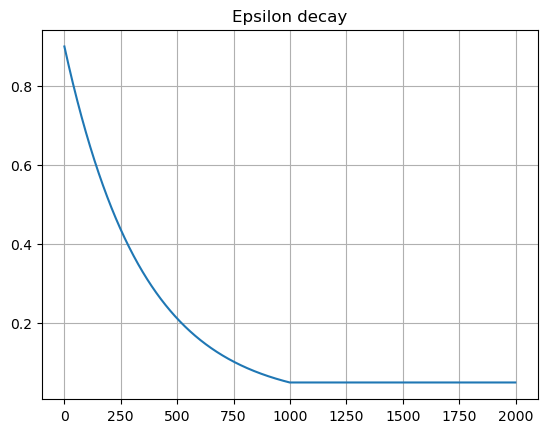

In [8]:
class ReplayMemory:
    """
    Store memory transitions (state, action, reward, next_state) and allow sampling it. Can combine subsequent states.

    Original sequence: s0, a0, r0, s1, a1, r1, s2, a2, r2, s3, a3, r3, s4, a4, r4, s5, a5, r5

    Combine subsequent states together and DQN learning rule:

        No concatenation: Q(s7, a7) = r7 + gamma * Q(s8, *)

        States window size of 1: Q((s6, s7), a7) = r7 + gamma * Q((s7, s8), *)   - each si is concatenated with previous si-1

        States window size of 2: Q((s5, s6, s7), a7) = r7 + gamma * Q((s6, s7, s8), *)   - each si is concatenated with si-2, si-1

    Done flags needed to distinct between normal, truncated or terminated states:
        0 - normal state transition (s,a,r,ns)
        1 - terminated: next_state is terminal state, agent needs to have Q(ns, *) = 0
        2 - truncated: environment stopped and next_state is not terminal state. Agent needs to learn using Q(ns, *)

    """
    def __init__(self, capacity, states_window_size=1):
        self.states_window_size = states_window_size

        self.states = deque([], maxlen=capacity)
        self.actions = deque([], maxlen=capacity)
        self.rewards = deque([], maxlen=capacity)
        self.done_flags = deque([], maxlen=capacity)
        self.next_states = deque([], maxlen=capacity)

    def observe(self, state, action, reward, terminated, truncated, next_state):
        self.states.append(state)
        self.actions.append(action)
        self.rewards.append(reward)
        self.done_flags.append(1 if terminated else (2 if truncated else 0))
        self.next_states.append(next_state)

    def sample_as_tensors(self, batch_size):
        sws = self.states_window_size

        S, A, R, D, NS = [], [], [], [], []
        while len(S) < batch_size:
            i = np.random.randint(sws - 1, len(self.states))

            # Make sure transitions chain (s[i - states_window_size], ..., s[i - 1], s[i]) not crossing episode boundary (defined by done flag)
            if any( self.done_flags[j] > 0 for j in range(i - sws + 1, i) ):
                continue

            S.append([self.states[j] for j in range(i - sws + 1, i + 1)])
            A.append(self.actions[i])
            R.append(self.rewards[i])
            D.append(self.done_flags[i])
            NS.append([self.next_states[j] for j in range(i - sws + 1, i + 1)])

        S = torch.as_tensor(np.array(S))
        A = torch.as_tensor(np.array(A))
        R = torch.as_tensor(np.array(R))
        D = torch.as_tensor(np.array(D))
        NS = torch.as_tensor(np.array(NS))
        return S, A, R, D, NS

    def __len__(self):
        return len(self.states)


@torch.no_grad()
def eval(device, env, states_window_size, dqn_model, max_episodes, max_episode_steps):
    """
    Test model performance playing environment
    """
    dqn_model.eval()

    rewards = []
    steps = []
    for episode_i in range(max_episodes):

        rewards.append(0)
        steps.append(0)

        state, info = env.reset()
        states_deque = deque(maxlen=states_window_size)
        states_deque.append(state)

        for step_i in range(max_episode_steps):

            if len(states_deque) < states_window_size:
                action = np.random.randint(0, dqn_model.ENV_ACTIONS)

            else:
                action_values = dqn_model.forward_numpy_one_state(device, states_deque)
                action = np.argmax(action_values)

            state, reward, terminated, truncated, info = env.step(action)

            rewards[-1] += reward
            steps[-1] += 1

            if terminated or truncated:
                break

            states_deque.append(state)
            assert len(states_deque) <= states_window_size

    print(f"Eval: episodes {max_episodes}, average episode sum rewards {np.mean(rewards)}, std {np.std(rewards)}. Average number of steps {np.mean(steps)}, std {np.std(steps)}")

def show_train_curves(train_curves):
    """
    Show training curves with their moving average
    """
    fig, ax = plt.subplots(nrows=1, ncols=len(train_curves))
    fig.set_size_inches(25, 12)

    if len(train_curves) == 1:
        ax = [ax]

    for ci, (label, points) in enumerate(train_curves.items()):

        N = max(2, len(points) // 100)
        cumsum = np.cumsum(np.insert(points, 0, 0))
        moving_average = (cumsum[N:] - cumsum[:-N]) / float(N)

        ax[ci].plot(points, label=label)
        ax[ci].plot(moving_average, linewidth=1, color='r', label=f"Moving average using {N} points window")
        ax[ci].set_ylabel(label)
        ax[ci].legend()
        ax[ci].grid(True)


class EpsilonExponentialDecay:
    """
    Implement function eps(time) which values are exponentially decaying, starting from value `start`, reaching value `end` after `steps` steps and keep value `end` afterwards
    """
    def __init__(self, start, end, steps):
        self.start = start
        self.end = end
        self.steps = steps

    def value(self, time):
        if time >= self.steps:
            return self.end

        # val(time) = a*b^time
        # val(0) = start
        #    => a*b^0 = start
        #    => a = start
        # val(steps - 1) = end
        #    => a*b^(steps - 1) = end
        #    => b^(steps - 1) = end / start
        #    => steps - 1 = log_b(end / start)
        #    => steps - 1 = log(end / start) / log(b)
        #    => log(b) = log(end / start) / (steps - 1)
        #    => b = exp( log(end / start) / (steps - 1) )
        b = math.exp( math.log(self.end / self.start) / (self.steps - 1) )
        return self.start * math.pow(b, time)


class DQN_Model(torch.nn.Module):
    """
    DQN Model which estimate Q(s, a)
    """
    def __init__(self, env):
        super().__init__()

        assert len(env.observation_space.shape) == 1

        self.ENV_STATE_SIZE = env.observation_space.shape[0]
        self.ENV_ACTIONS = env.action_space.n

        hidden_size = 64

        self.dqn_model = torch.nn.Sequential(
            torch.nn.Linear(self.ENV_STATE_SIZE, hidden_size),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_size, self.ENV_ACTIONS),
        )

    def forward(self, state):
        B = state.shape[0]  # batch size
        assert state.shape == (B, self.ENV_STATE_SIZE)

        action_values = self.dqn_model(state)
        return action_values

    def forward_numpy_one_state(self, device, states):
        states = np.array([state for state in states])
        assert states.shape == (1, self.ENV_STATE_SIZE)

        action_values = self.dqn_model(torch.as_tensor(states).to(device)).detach().cpu().numpy()[0, :]
        return action_values


def show_epsilon_decay():
    decay = EpsilonExponentialDecay(start=0.9, end=0.05, steps=1000)
    plt.plot([decay.value(time) for time in range(2000)])
    plt.title('Epsilon decay')
    plt.grid()


show_epsilon_decay()

# DQN on LunarLander

Implementation based on: https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html

  0%|          | 0/5000 [00:00<?, ?it/s]

Eval: episodes 100, average episode sum rewards 134.8088702803263, std 80.36644212947391. Average number of steps 434.54, std 82.77963759282835


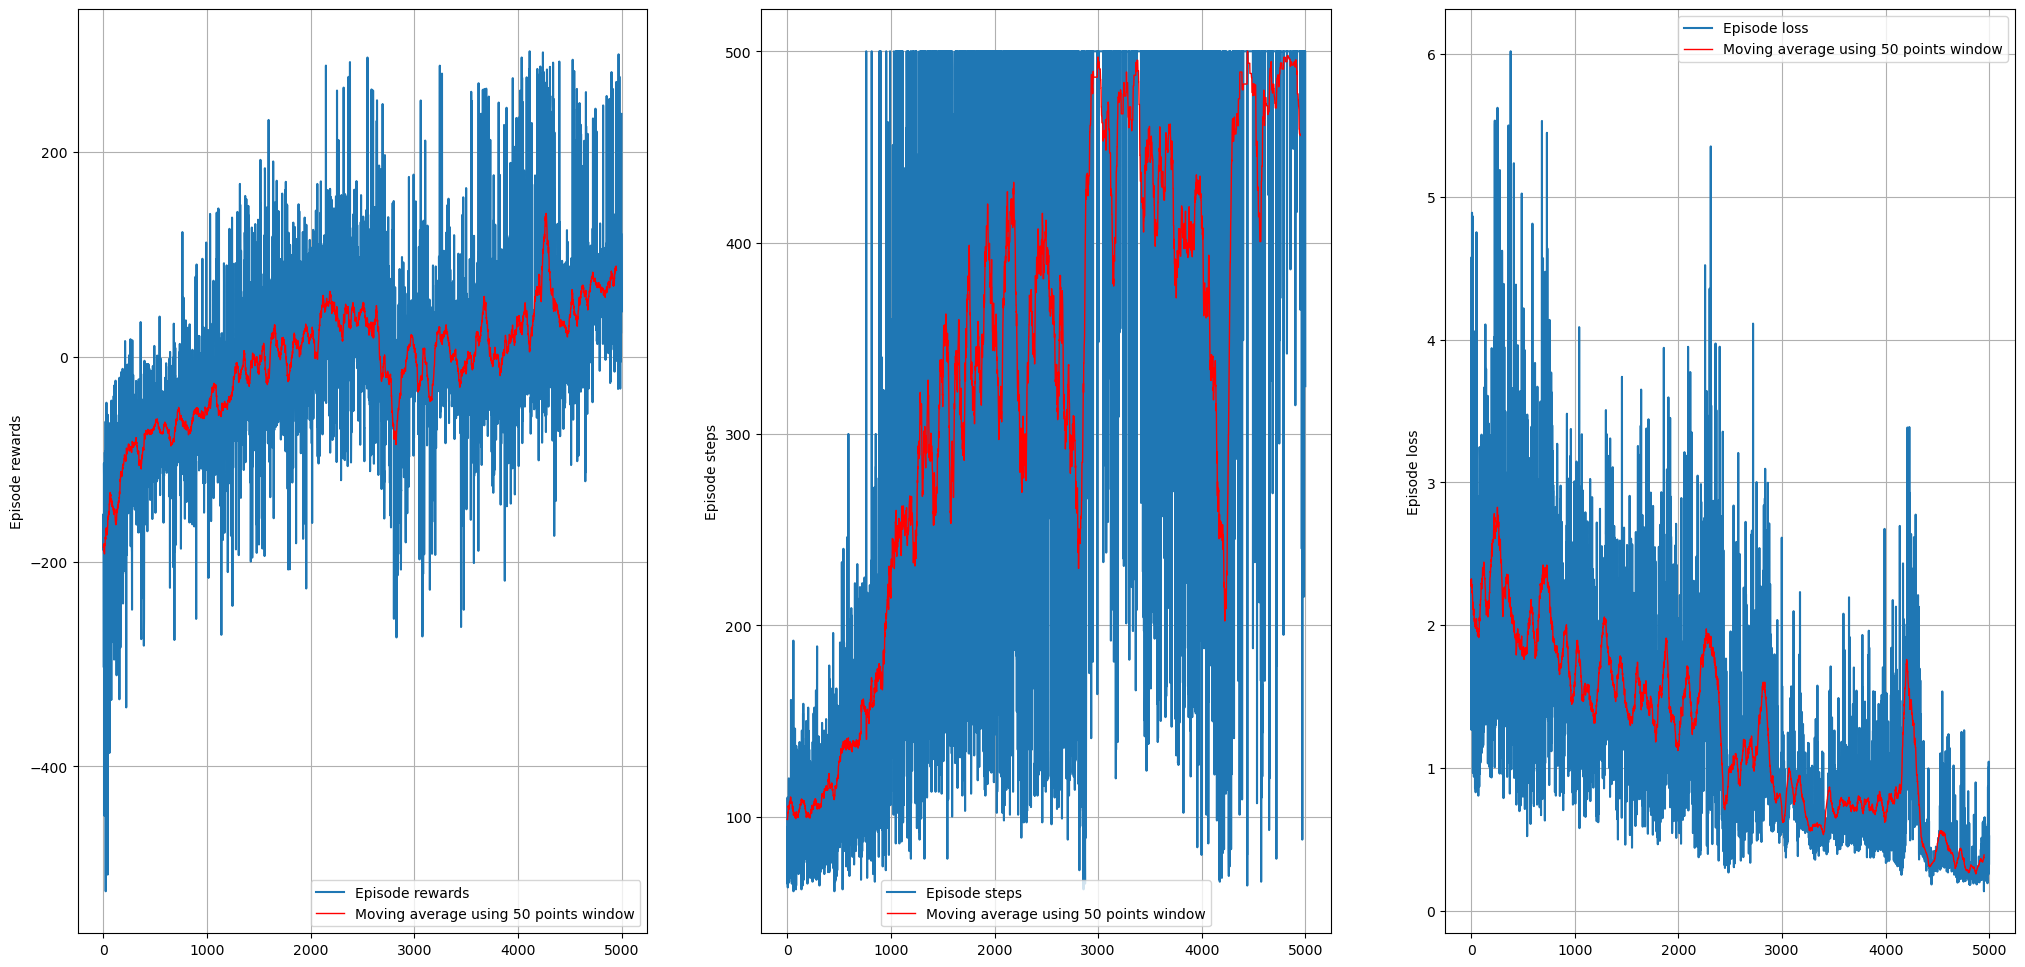

In [12]:
def dqn_impl(device, env, learning_rate, discount_factor, batch_size, memory_capacity, max_episodes, max_episode_steps):
    dqn_model = DQN_Model(env)

    dqn_optimizer = torch.optim.AdamW(dqn_model.parameters(), lr=learning_rate)

    epsilon_decay = EpsilonExponentialDecay(start=0.9, end=0.05, steps=max_episodes)

    experience_replay = ReplayMemory(capacity=memory_capacity, states_window_size=1)  # Use 1 frame of states to learn, LunarLander is simple enough

    train_curves = defaultdict(list)

    for episode_i in tqdm(range(max_episodes)):
        log_episode_reward = 0
        log_episode_steps = 0

        dqn_model.eval()
        with torch.no_grad():

            state, info = env.reset()

            for step_i in range(max_episode_steps):

                if np.random.rand() <= epsilon_decay.value(episode_i):
                    action = np.random.randint(0, dqn_model.ENV_ACTIONS)

                else:
                    action_values = dqn_model.forward_numpy_one_state(device, [state])
                    action = np.argmax(action_values)

                next_state, reward, terminated, truncated, info = env.step(action)

                experience_replay.observe(state, action, reward, terminated, truncated, next_state)

                log_episode_reward += reward
                log_episode_steps += 1

                if terminated or truncated:
                    break

                state = next_state

            S, A, R, D, NS = experience_replay.sample_as_tensors(batch_size)
            S = S.squeeze(1)
            NS = NS.squeeze(1)
            # print("S", S.shape, S.dtype)     # S torch.Size([batch_size, 8]) torch.float32
            # print("A", A.shape, A.dtype)     # A torch.Size([batch_size]) torch.int64
            # print("R", R.shape, R.dtype)     # R torch.Size([batch_size]) torch.float64
            # print("D", D.shape, D.dtype)     # D torch.Size([batch_size]) torch.int64
            # print("NS", NS.shape, NS.dtype)  # NS torch.Size([batch_size, 8]) torch.float32

            next_state_values = dqn_model(NS).max(1).values   # still in eval - no gradient goes here
            next_state_values *= (D != 1)   # zero value where state was terminal  (D=0 for normal transitions, D=1 for terminal, D=2 for truncated)
            # print("next_state_values", next_state_values.shape, next_state_values.dtype)

        dqn_model.train()

        state_all_action_values = dqn_model(S)
        # print("state_all_action_values", state_all_action_values.shape, state_all_action_values.dtype)

        state_action_values = state_all_action_values.gather(1, A.unsqueeze(1)).squeeze()
        # print("state_action_values", state_action_values.shape, state_action_values.dtype)

        expected_state_action_values = R + discount_factor * next_state_values
        # print("expected_state_action_values", expected_state_action_values.shape, expected_state_action_values.dtype)

        loss = torch.nn.functional.smooth_l1_loss(state_action_values, expected_state_action_values)  # Huber loss
        log_loss = loss.item()
        dqn_optimizer.zero_grad(set_to_none=True)
        loss.backward()
        torch.nn.utils.clip_grad_value_(dqn_model.parameters(), 100)   # In-place gradient clipping
        dqn_optimizer.step()

        train_curves['Episode rewards'].append(log_episode_reward)
        train_curves['Episode steps'].append(log_episode_steps)
        train_curves['Episode loss'].append(log_loss)

    return dqn_model, dqn_model, train_curves

def solve():
    env = gym.make('LunarLander-v2')

    device = torch.device('cpu')

    dqn_model, dqn_model, train_curves = dqn_impl(
        device=device,
        env=env,
        learning_rate=1e-2,
        discount_factor=0.99,
        batch_size=128,
        memory_capacity=10000,
        max_episodes=5000,
        max_episode_steps=500)

    show_train_curves(train_curves)

    eval(
        device,
        env,
        states_window_size=1,
        dqn_model=dqn_model,
        max_episodes=100,
        max_episode_steps=500)

    return env, dqn_model, dqn_model

env, dqn_model, dqn_model = solve()

## Use two networks for stability

Same algorithm as in cell above, but here we have two equal DQN models:

* Policy model (named `dqn_model` in the implementation below) - used for navigation and being trained

* Target model - this model is used only in computing Q values of the next state, when we need to compute `R + Q(next_state, action)` during training. Target model is soft-updated version of policy model

In [31]:
def dqn_two_networks_impl(
        device,
        dqn_model,
        target_model,
        env,
        states_window_size,
        learning_rate,
        discount_factor,
        batch_size,
        memory_capacity,
        soft_update_tau,
        max_episodes,
        max_episode_steps):
    target_model.load_state_dict(dqn_model.state_dict())
    target_model.eval()   # Never being trained, its parameters are moving average of the policy model (`dqn_model`) parameter values
    dqn_model.to(device)
    target_model.to(device)

    dqn_optimizer = torch.optim.AdamW(dqn_model.parameters(), lr=learning_rate)

    epsilon_decay = EpsilonExponentialDecay(start=0.9, end=0.05, steps=max_episodes)

    experience_replay = ReplayMemory(capacity=memory_capacity, states_window_size=states_window_size)

    train_curves = defaultdict(list)

    for episode_i in tqdm(range(max_episodes)):
        log_episode_reward = 0
        log_episode_steps = 0

        dqn_model.eval()
        with torch.no_grad():

            state, info = env.reset()
            states_deque = deque(maxlen=states_window_size)
            states_deque.append(state)

            for step_i in range(max_episode_steps):

                if len(states_deque) < states_window_size or np.random.rand() <= epsilon_decay.value(episode_i):
                    action = np.random.randint(0, dqn_model.ENV_ACTIONS)

                else:
                    action_values = dqn_model.forward_numpy_one_state(device, states_deque)
                    action = np.argmax(action_values)

                next_state, reward, terminated, truncated, info = env.step(action)

                experience_replay.observe(state, action, reward, terminated, truncated, next_state)

                log_episode_reward += reward
                log_episode_steps += 1

                if terminated or truncated:
                    break

                state = next_state
                states_deque.append(state)
                assert len(states_deque) <= states_window_size

            S, A, R, D, NS = experience_replay.sample_as_tensors(batch_size)
            S = S.to(device)
            A = A.to(device)
            R = R.to(device)
            D = D.to(device)
            NS = NS.to(device)

            S = S.squeeze(1)
            NS = NS.squeeze(1)
            # print("S", S.shape, S.dtype)     # S torch.Size([batch_size, 8]) torch.float32
            # print("A", A.shape, A.dtype)     # A torch.Size([batch_size]) torch.int64
            # print("R", R.shape, R.dtype)     # R torch.Size([batch_size]) torch.float64
            # print("D", D.shape, D.dtype)     # D torch.Size([batch_size]) torch.int64
            # print("NS", NS.shape, NS.dtype)  # NS torch.Size([batch_size, 8]) torch.float32

            next_state_values = target_model(NS).max(1).values   # still in eval - no gradient goes here.
            next_state_values *= (D != 1)   # zero value where state was terminal  (D=0 for normal transitions, D=1 for terminal, D=2 for truncated)
            # print("next_state_values", next_state_values.shape, next_state_values.dtype)

        dqn_model.train()

        state_all_action_values = dqn_model(S)
        # print("state_all_action_values", state_all_action_values.shape, state_all_action_values.dtype)

        state_action_values = state_all_action_values.gather(1, A.unsqueeze(1)).squeeze()
        # print("state_action_values", state_action_values.shape, state_action_values.dtype)

        expected_state_action_values = R + discount_factor * next_state_values
        # print("expected_state_action_values", expected_state_action_values.shape, expected_state_action_values.dtype)

        loss = torch.nn.functional.smooth_l1_loss(state_action_values, expected_state_action_values)  # Huber loss
        log_loss = loss.item()
        dqn_optimizer.zero_grad(set_to_none=True)
        loss.backward()
        torch.nn.utils.clip_grad_value_(dqn_model.parameters(), 100)   # In-place gradient clipping
        dqn_optimizer.step()

        target_model_state_dict = target_model.state_dict()
        dqn_model_state_dict = dqn_model.state_dict()
        for key in dqn_model_state_dict.keys():
            target_model_state_dict[key] = dqn_model_state_dict[key] * soft_update_tau + target_model_state_dict[key] * (1 - soft_update_tau)
        target_model.load_state_dict(target_model_state_dict)

        train_curves['Episode rewards'].append(log_episode_reward)
        train_curves['Episode steps'].append(log_episode_steps)
        train_curves['Episode loss'].append(log_loss)

    return dqn_model, target_model, train_curves

  0%|          | 0/10000 [00:00<?, ?it/s]

Eval: episodes 100, average episode sum rewards 174.55579262441984, std 78.03212116973661. Average number of steps 333.16, std 125.63205960263487


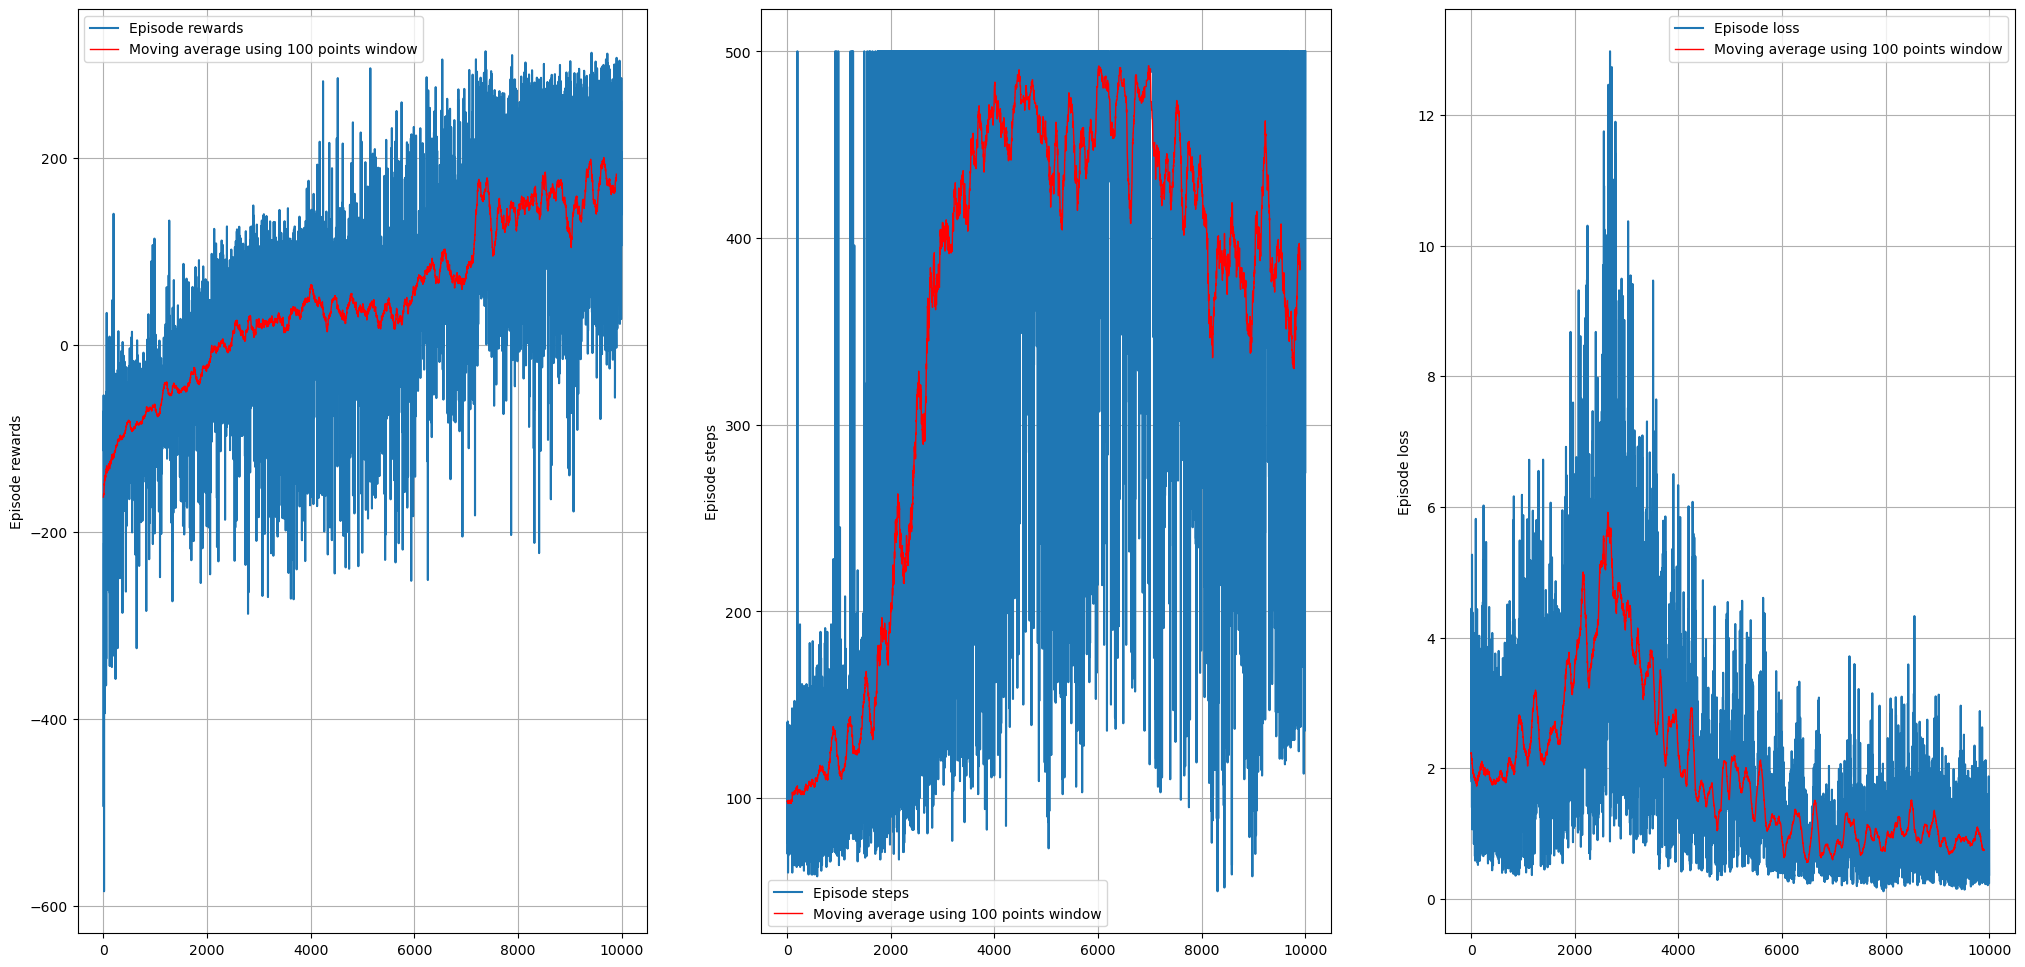

In [32]:
def solve():
    env = gym.make('LunarLander-v2')

    device = torch.device('cpu')

    dqn_model, target_model, train_curves = dqn_two_networks_impl(
        dqn_model = DQN_Model(env),
        target_model = DQN_Model(env),
        device=device,
        env=env,
        states_window_size=1,
        learning_rate=1e-2,
        discount_factor=0.99,
        batch_size=128,
        memory_capacity=10000,
        soft_update_tau=0.1,
        max_episodes=10000,
        max_episode_steps=500)

    show_train_curves(train_curves)

    eval(
        device,
        env,
        states_window_size=1,
        dqn_model=dqn_model,
        max_episodes=100,
        max_episode_steps=500)

    return env, dqn_model, target_model

env, dqn_model, target_model = solve()

# DQN on Pong

In [33]:
print(torch.cuda.is_available())

def show_usage():
    usage=resource.getrusage(resource.RUSAGE_SELF)
    print(f"usertime={usage[0]} systime={usage[1]} mem={usage[2]/1024.0} mb")

show_usage()

True
usertime=7433.046549 systime=231.32591 mem=1479.828125 mb


device cuda:0


  0%|          | 0/10000 [00:00<?, ?it/s]

Eval: episodes 100, average episode sum rewards 0.0, std 0.0. Average number of steps 500.0, std 0.0


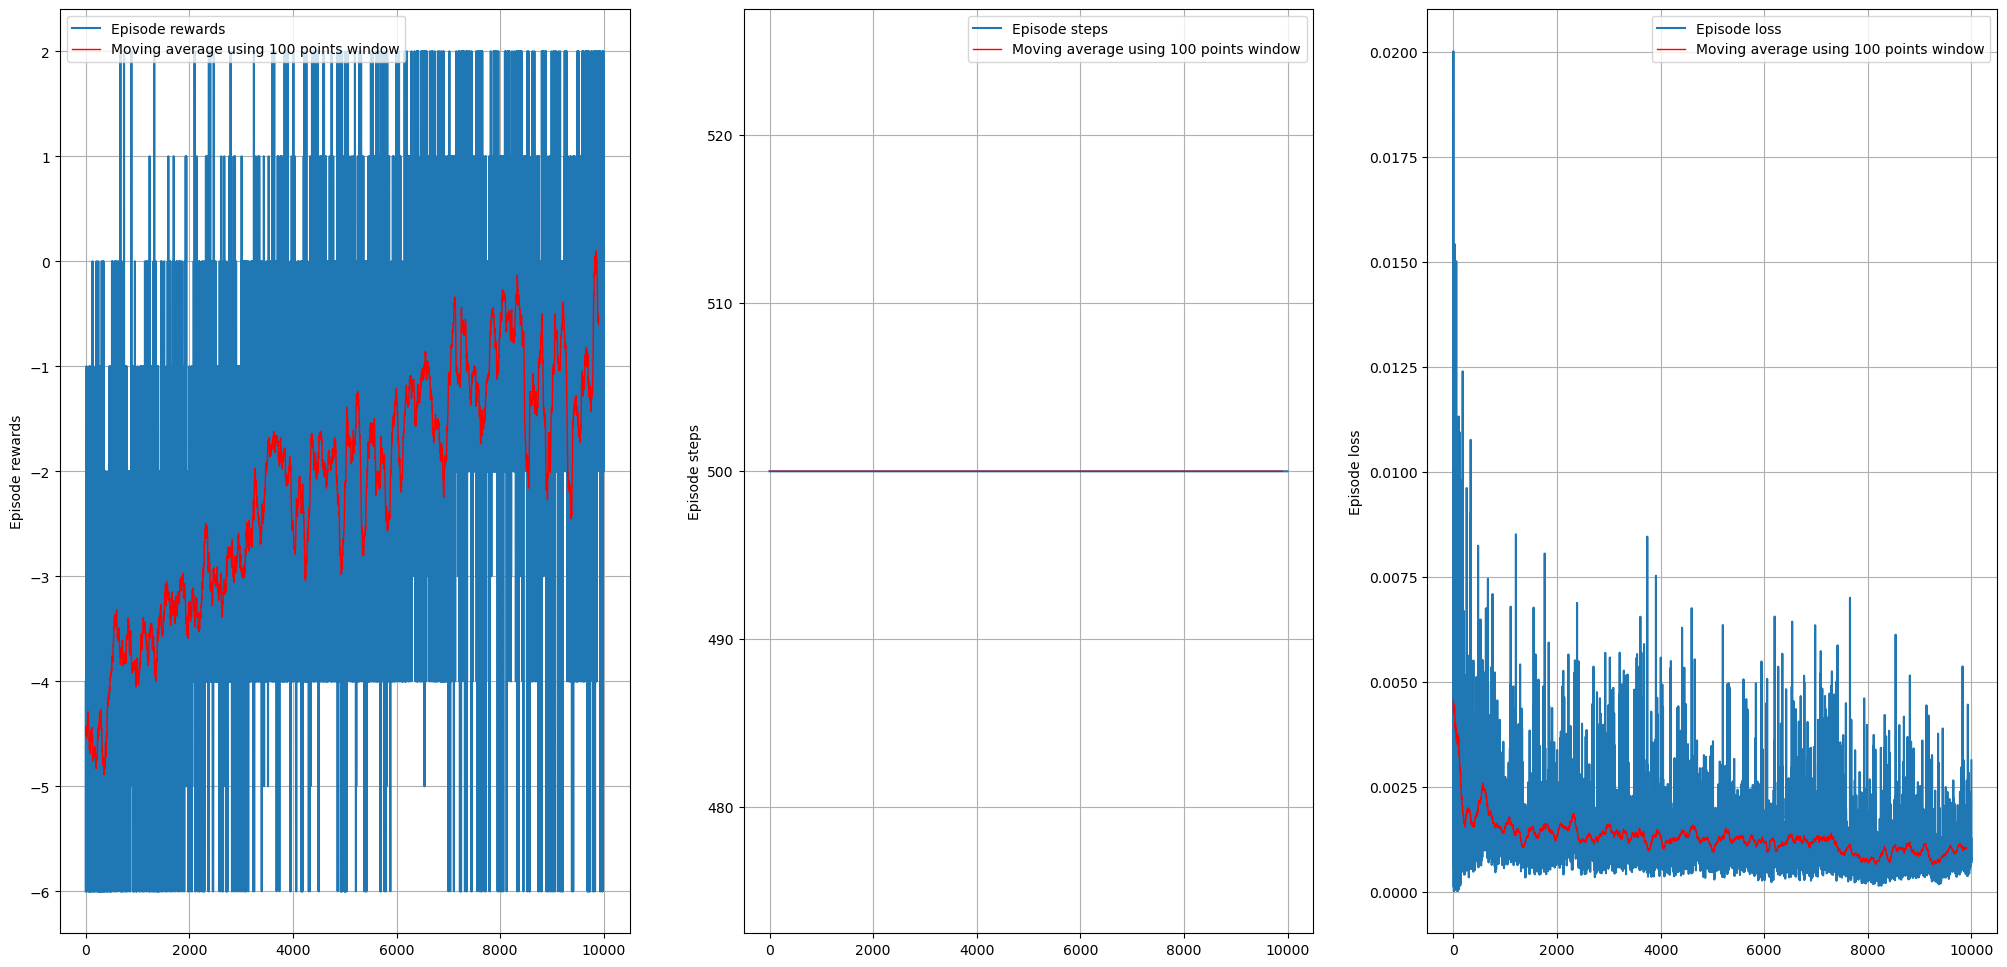

In [127]:
class PongWrapper:
    """
    Make Pong environment a bit easier: scale state observation and reduce action space
    """
    def __init__(self):

        def _transform_observation(obs):   # Original observation shape (210, 160), dtype=np.uint8
            obs[obs == 107] = 0  # background
            obs[obs == 87] = 0   # background
            obs[obs != 0] = 1    # paddles and ball
            obs = obs[34:194, :]
            obs = obs.reshape(80, 2, 80, 2).max(axis=(1, 3))   # max pooling using kernel (2, 2), stride (2, 2)
            return obs.astype(np.float32)

        # pixel values in range 70 <= pixel <= 185
        env = gym.make("ALE/Pong-v5", obs_type='grayscale', frameskip=2, repeat_action_probability=0, render_mode=None)
        # env = gym.wrappers.TransformObservation(env, lambda obs: ((cv2.resize(obs[32:162, :], dsize=(80, 80), interpolation=cv2.INTER_CUBIC)).astype(np.float32) - 128) / 57)
        # env = gym.wrappers.TransformObservation(env, lambda obs: ((obs[35:195, :][::2, ::2]).astype(np.float32) - 128) / 57)
        self.env = gym.wrappers.TransformObservation(env, _transform_observation)

        self.action_space = gym.spaces.Discrete(2)   # Pong has only actions 2 and 3 relevant

    def reset(self):
        return self.env.reset()

    def step(self, action):
        return self.env.step(action + 2)


class DQN_Pong_Model(torch.nn.Module):
    """
    DQN Model which estimate Q(s, a)
    """
    def __init__(self, env):
        super().__init__()

        self.ENV_STATE_SHAPE = (2, 80, 80)
        self.ENV_ACTIONS = env.action_space.n

        self.dqn_model = torch.nn.Sequential(         # input: (CWS=2, 80, 80)
            # torch.nn.LayerNorm(normalized_shape=(???,)) if use_layernorm else torch.nn.Identity(),
            torch.nn.Conv2d(2, 8, kernel_size=4, stride=2),    # output: (8, 39, 39)
            torch.nn.ReLU(),
            torch.nn.Conv2d(8, 16, kernel_size=3, stride=2),    # output: (16, 19, 19)
            torch.nn.ReLU(),
            torch.nn.Conv2d(16, 32, kernel_size=3, stride=2),    # output: (32, 9, 9)
            torch.nn.ReLU(),
            torch.nn.Conv2d(32, 64, kernel_size=3, stride=3),    # output: (64, 3, 3)
            torch.nn.Flatten(),   # output: (576=64*3*3,)
            torch.nn.Linear(576, self.ENV_ACTIONS),
        )

    def forward(self, state):
        B = state.shape[0]  # batch size
        assert state.shape == (B, *self.ENV_STATE_SHAPE)

        action_values = self.dqn_model(state)
        return action_values

    def forward_numpy_one_state(self, device, states_deque):
        states = np.array([state for state in states_deque])
        assert states.shape == self.ENV_STATE_SHAPE

        states = np.expand_dims(states, axis=0)
        action_values = self.dqn_model(torch.as_tensor(states).to(device)).detach().cpu().numpy()[0, ...]
        return action_values


def solve():
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    print("device", device)

    env = PongWrapper()

    dqn_model, target_model, train_curves = dqn_two_networks_impl(
        dqn_model=DQN_Pong_Model(env),
        target_model=DQN_Pong_Model(env),
        device=device,
        env=env,
        states_window_size=2,  # Use 2 consequent states for Pong environment (to help model see velocity of the ball)
        learning_rate=1e-3,
        discount_factor=0.99,
        batch_size=128,
        memory_capacity=10000,
        soft_update_tau=0.1,
        max_episodes=10000,
        max_episode_steps=500)

    show_train_curves(train_curves)

    eval(
        device=device,
        env=env,
        states_window_size=2,
        dqn_model=dqn_model,
        max_episodes=100,
        max_episode_steps=500)

    return env, dqn_model, target_model

env, dqn_model, target_model = solve()

In [128]:
show_usage()

usertime=17104.120178 systime=272.627304 mem=1630.51953125 mb


This is what agent sees:


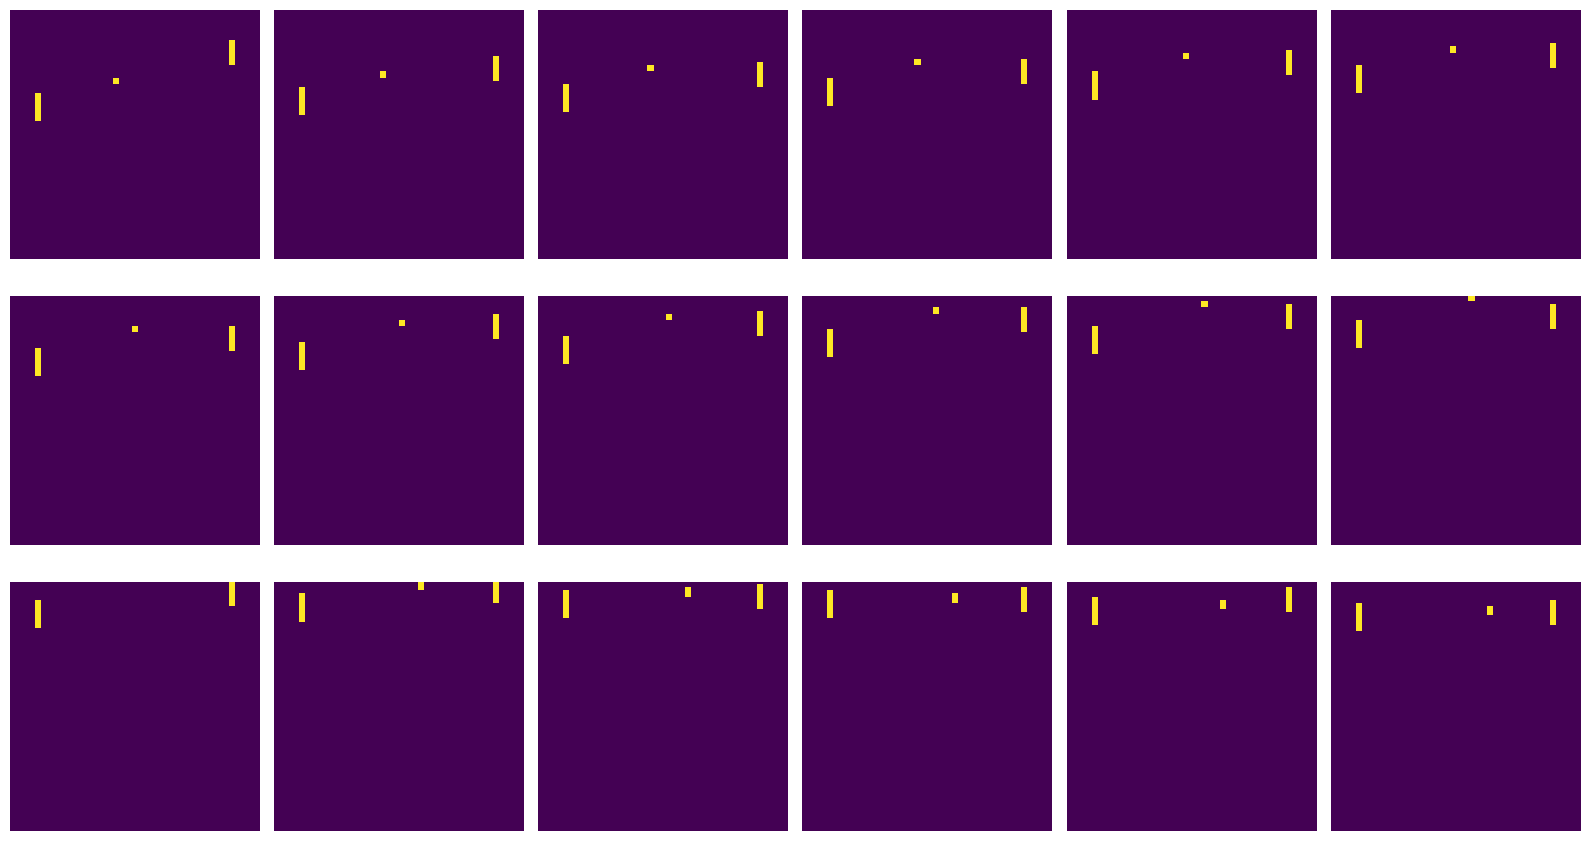

In [129]:
def show_env_output(env):
    print("This is what agent sees:")

    ROWS = 3
    COLS = 6

    fig, ax = plt.subplots(nrows=ROWS, ncols=COLS)
    fig.set_size_inches(16, 9)

    states = deque(maxlen=ROWS * COLS)

    state, info = env.reset()

    for step_i in range(100):
        action = np.random.randint(0, env.action_space.n)

        state, reward, terminated, truncated, info = env.step(action)
        if terminated or truncated:
            break

        states.append(state)

    for ri in range(ROWS):
        for ci in range(COLS):
            obs = states[ri * COLS + ci]
            ax[ri, ci].imshow(obs)
            ax[ri, ci].axis('off')

    fig.tight_layout()

show_env_output(env)